In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
args = {
    'epoch_num': 20,
    'lr': 1e-3,
    'weight_decay': 8e-4,
    'batch_size': 20
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(f'Using device: {args["device"]}')



Using device: cuda


In [3]:
class CatDogClassifier(nn.Module):
    def __init__(self):
        super(CatDogClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1)  
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x  # Saída como logits


In [4]:
data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
train_set = datasets.ImageFolder(root='./training_set/training_set', transform=data_transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.ImageFolder(root='./test_set/test_set', transform=data_transform)

test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

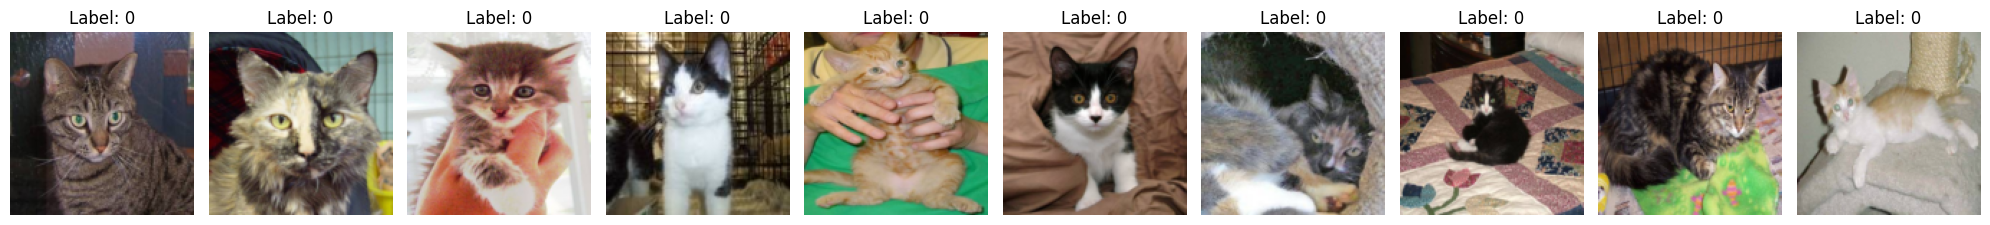

In [6]:
def denormalize(img):
    return img * 0.5 + 0.5  

fig, axes = plt.subplots(1, 10, figsize=(20, 5))  
for i in range(10):
    img, label = train_set[i]
    img = denormalize(img)  
    axes[i].imshow(img.permute(1, 2, 0))
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [7]:
net = CatDogClassifier()

net = net.to(args['device'])

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

In [8]:
def train_model(net, train_loader, criterion, optimizer, device, epoch_num):
    net.train() 

    for epoch in range(epoch_num):
        epoch_loss = 0.0  

        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)  
            optimizer.zero_grad() 
            outputs = net(images)  
            loss = criterion(outputs, labels) 
            loss.backward()  
            optimizer.step() 

            epoch_loss += loss.item() * images.size(0) 

        epoch_loss /= len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epoch_num}, Loss: {epoch_loss:.4f}")

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def test_model(net, test_loader, criterion, device):
    net.eval() 
    test_loss = 0.0
    all_outputs = []
    all_labels = []

    with torch.no_grad():  
        for images, labels in test_loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)  
            outputs = net(images)  
            probabilities = torch.sigmoid(outputs)  
            loss = criterion(outputs, labels)  
            test_loss += loss.item() * images.size(0)  

            all_outputs.append(probabilities.cpu())
            all_labels.append(labels.cpu())

    test_loss /= len(test_loader.dataset)

    all_outputs = torch.cat(all_outputs).squeeze(1)
    all_labels = torch.cat(all_labels).squeeze(1)

    predicted = (all_outputs > 0.5).int()

    accuracy = accuracy_score(all_labels, predicted)
    precision = precision_score(all_labels, predicted)
    recall = recall_score(all_labels, predicted)
    f1 = f1_score(all_labels, predicted)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    torch.save(net.state_dict(), 'cat_dog_classifier.pth')

    return {
        "loss": test_loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
    }


In [41]:
train_model(net, train_loader, criterion, optimizer, args['device'], args['epoch_num'])

Epoch 1/20, Loss: 0.0929
Epoch 2/20, Loss: 0.0628
Epoch 3/20, Loss: 0.0488
Epoch 4/20, Loss: 0.0475
Epoch 5/20, Loss: 0.0652
Epoch 6/20, Loss: 0.0584
Epoch 7/20, Loss: 0.0459
Epoch 8/20, Loss: 0.0633
Epoch 9/20, Loss: 0.0457
Epoch 10/20, Loss: 0.0378
Epoch 11/20, Loss: 0.0453
Epoch 12/20, Loss: 0.0674
Epoch 13/20, Loss: 0.0498
Epoch 14/20, Loss: 0.0870
Epoch 15/20, Loss: 0.0794
Epoch 16/20, Loss: 0.0460
Epoch 17/20, Loss: 0.0369
Epoch 18/20, Loss: 0.0302
Epoch 19/20, Loss: 0.0447
Epoch 20/20, Loss: 0.0402


In [12]:
test_model(net, test_loader, criterion, args['device'])

Test Loss: 0.5166
Accuracy: 0.8685
Precision: 0.8791
Recall: 0.8547
F1 Score: 0.8667


{'loss': 0.516599453238055,
 'accuracy': 0.8685121107266436,
 'precision': 0.8790650406504065,
 'recall': 0.8547430830039525,
 'f1_score': 0.8667334669338678}

In [33]:
def infer_image(model, image_path, device):

    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  

    image = image.to(device)

    model.eval()
    
    with torch.no_grad():
        # Faz a inferência
        output = model(image)
        probability = torch.sigmoid(output).item() 

    print(f'Probabilidade: {probability}')
    if probability > 0.5:
        return "Cachorro"
    else:
        return "Gato"

In [58]:
inference = infer_image(net, 'gato.jpg', args['device'])
print(inference)


Probabilidade: 1.2716908486254397e-06
Gato


In [43]:
# save model
torch.save(net.state_dict(), 'cat_dog_classifier.pth')

